[A Mathematical Theory of Communication :: Claude Shannon 1948](https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf) <br>
[MNIST Database](http://yann.lecun.com/exdb/mnist/)

In [1]:
import numpy as np
import matplotlib.pylab as plt
from tqdm import trange

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import torch

---

### DATA

In [3]:
def fetch(url):
    import os, requests, gzip, hashlib, numpy
    filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
    else:
        with open(filepath, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return numpy.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [4]:
x_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape(-1, 28, 28) / 255.0
y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
x_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[0x10:].reshape(-1, 28, 28) / 255.0
y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Min: 0.0 Max: 1.0


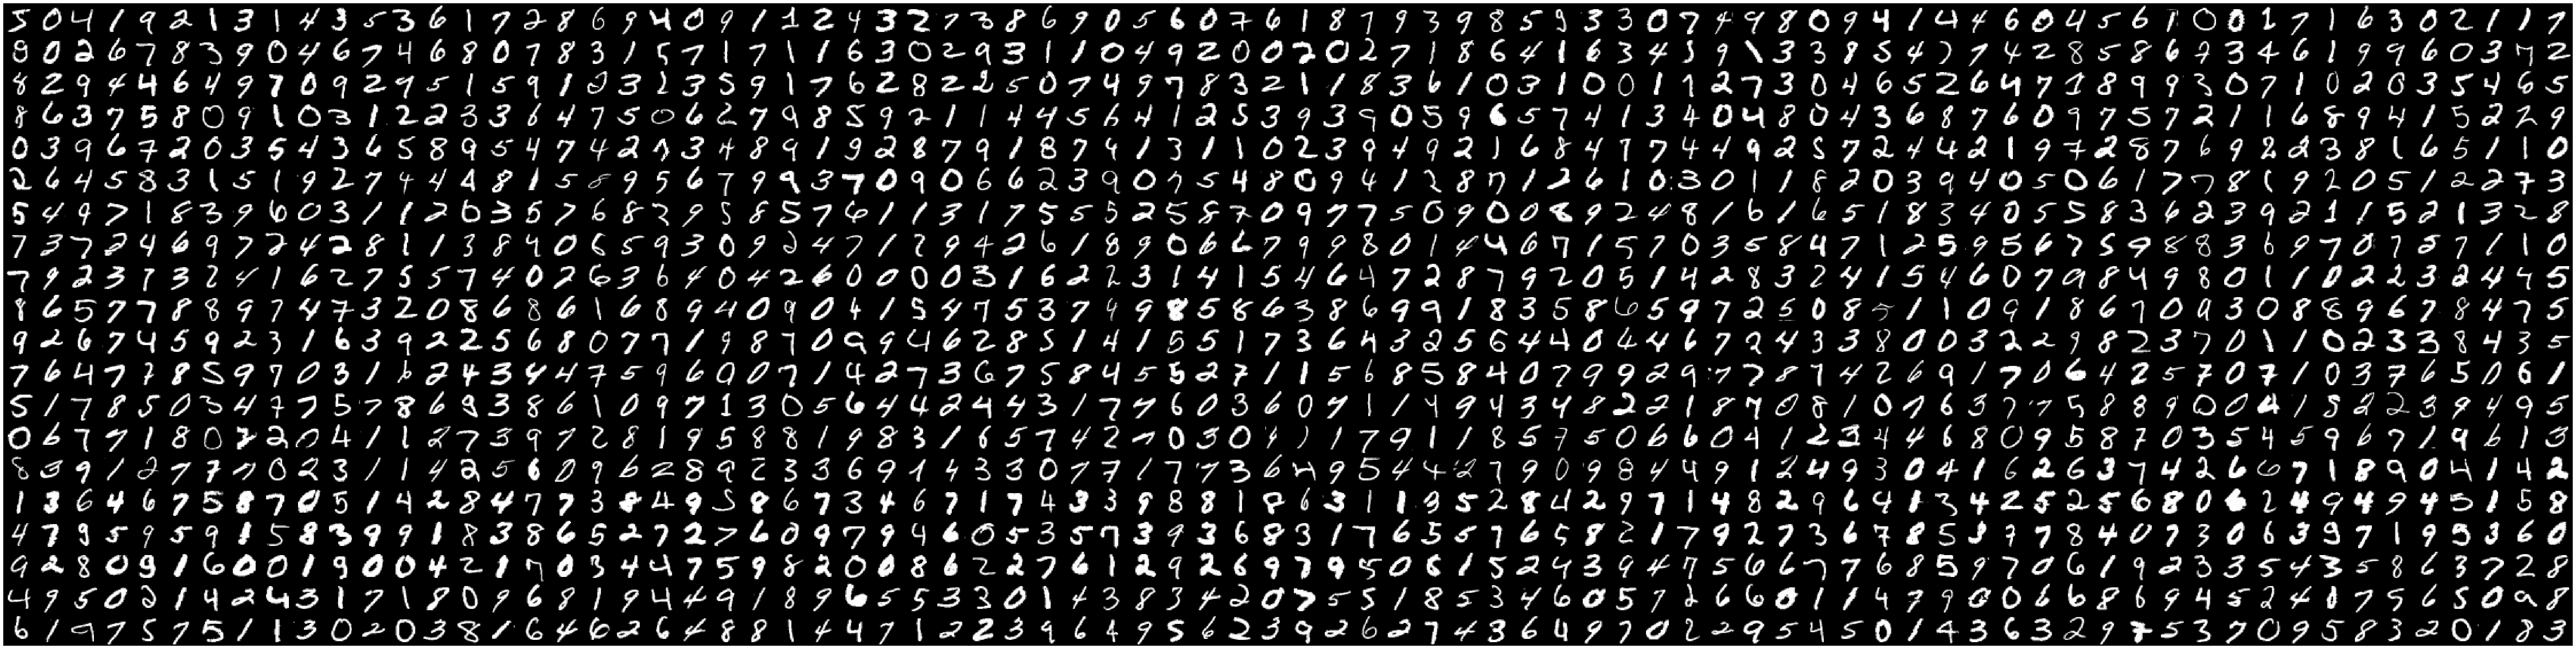

In [5]:
result = np.concatenate([np.concatenate(x_train[i*80:(i+1)*80], axis=1) for i in range(20)])

plt.figure(figsize=(80,20))
plt.imshow(result, 'gray')
plt.axis('off')
plt.tight_layout()

print('Min:', np.min(x_train), 'Max:', np.max(x_train))

In [6]:
# Shannon (1948) - Negative log of the probability of event
# https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf
print("Information Measure:", -torch.tensor(1/len(class_names)).log().numpy())

Information Measure: 2.3025851


---

### TRAINING

In [7]:
# Model
n_embd = x_train[0].shape[0] * x_train[0].shape[1]
n_hidden = 128
n_classes = len(class_names)

w1 = torch.randn((n_embd, n_hidden)) * 0.01
b1 = torch.randn(n_hidden) * 0.01
w2 = torch.randn((n_hidden, n_classes))
b2 = torch.randn(n_classes)

parameters = [w1, b1, w2, b2]
print("Nparams:", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Nparams: 101770


In [8]:
bs = 128
lr = 0.01
simlen = 1000

lossi, accuracies = [], []

for i in (t := trange(simlen)):

    idx = np.random.randint(0, x_train.shape[0], size=bs)
    X = torch.tensor(x_train[idx].reshape((-1,28*28))).float()
    Y = torch.tensor(y_train[idx]).long()

    # Forward pass
    fc = X @ w1 + b1
    act = torch.tanh(fc)
    logits = act @ w2 + b2

    counts = torch.exp(logits) # Exponentiate into fake counts
    prob = counts / torch.sum(counts, 1, keepdims=True) # Normalise into a probability
    loss = -prob[torch.arange(bs), Y].log().mean() # Average negative log likelihood

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # SGD
    for p in parameters:
        p.data -= lr * p.grad

    pred = torch.argmax(logits, dim=1)
    accuracy = (pred == Y).float().mean()

    lossi.append(loss.item())
    accuracies.append(accuracy.item())

    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

loss 0.28 accuracy 0.91: 100%|██████████| 1000/1000 [00:03<00:00, 321.75it/s]


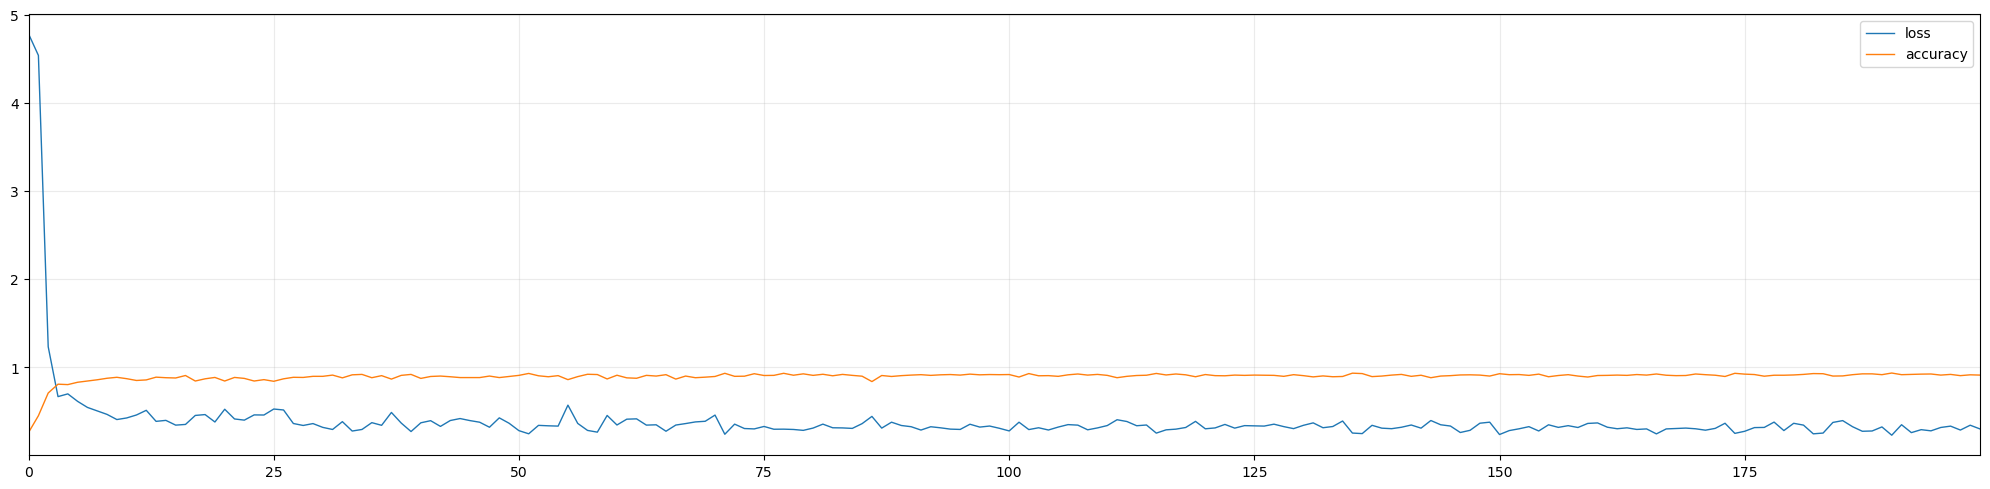

In [9]:
avg_loss = torch.tensor(lossi).view(-1, 5).mean(1)
avg_acc = torch.tensor(accuracies).view(-1, 5).mean(1)

plt.figure(figsize=(20,5))
plt.plot(avg_loss, lw=1, label='loss'), plt.plot(avg_acc, lw=1, label='accuracy')
plt.xlim(0, len(avg_loss)-1)
plt.grid(alpha=0.25), plt.legend()
plt.tight_layout()

---

### INFERENCE

In [10]:
l1 = torch.tanh(torch.tensor(x_test.reshape((-1,28*28))).float() @ w1 + b1)
l2 = l1 @ w2 + b2

counts = torch.exp(l2) # Exponentiate into fake counts
prob = counts / torch.sum(counts, 1, keepdims=True) # Normalise into a probability

predictions = torch.argmax(l2, dim=1)
print('Accuracy:', (y_test == predictions.numpy()).mean())

Accuracy: 0.9164


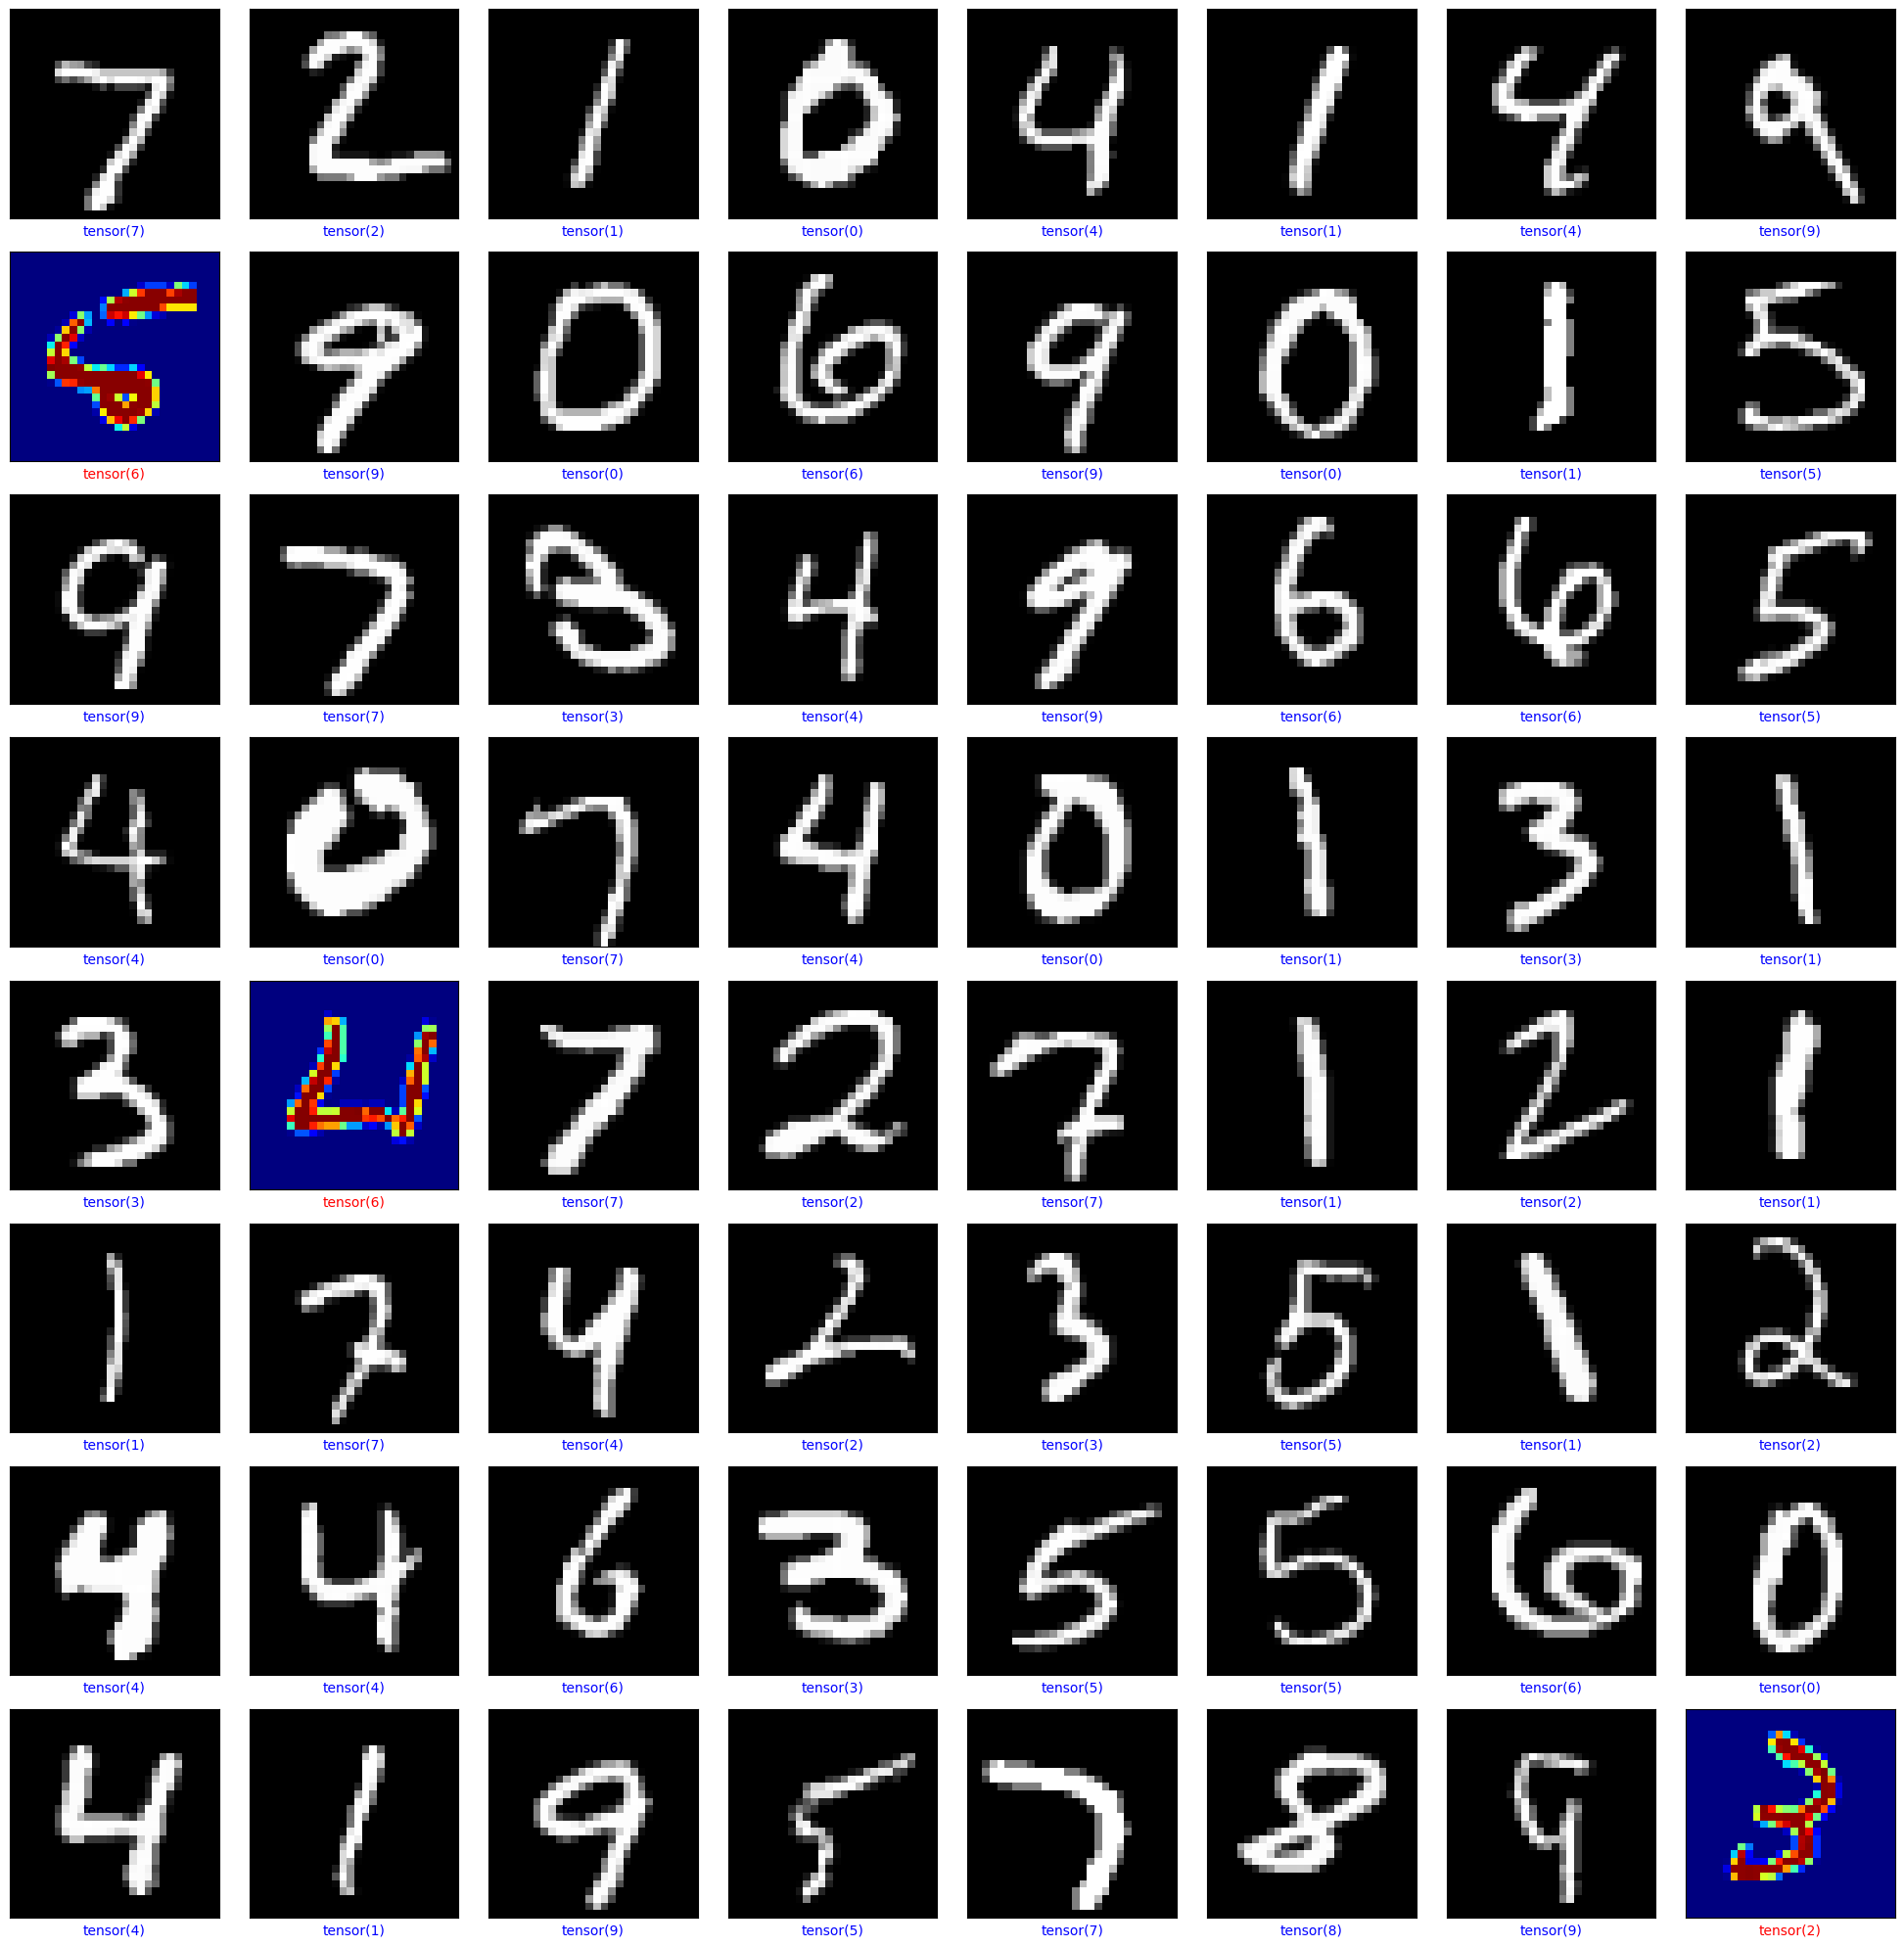

In [11]:
plt.figure(figsize=(20,20))
for i in range(64):

    if y_test[i] == predictions[i]:
        color = 'blue'
        grade = 'gray'
    else:
        color = 'red'
        grade = 'jet'

    plt.subplot(8, 8, i+1)
    plt.imshow(x_test[i], grade)
    plt.xlabel(predictions[i], color=color)
    plt.xticks([]), plt.yticks([])
    plt.grid(False), plt.tight_layout()

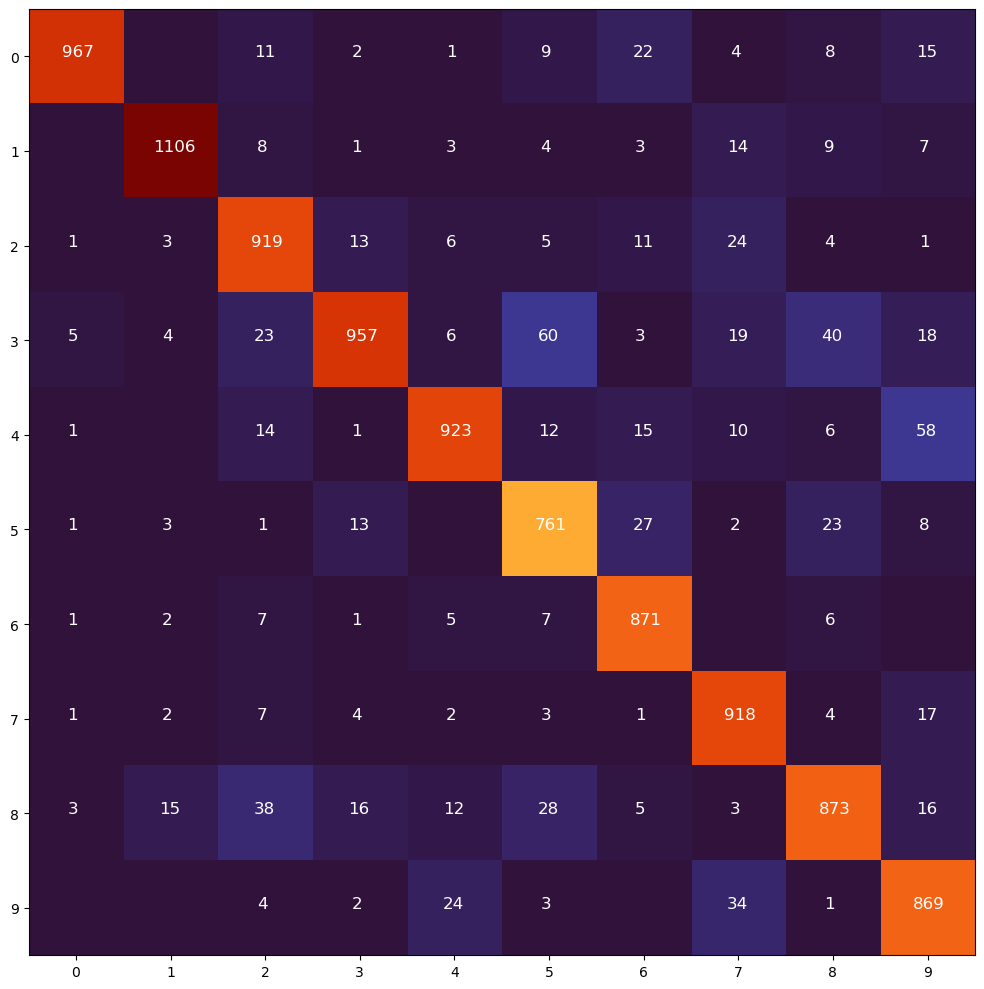

In [12]:
confusions = np.zeros([10, 10], np.float32)
bundled = zip(predictions, y_test)

plt.figure(figsize=(10,10))
for predicted, actual in bundled:
    confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.imshow(confusions, 'turbo')

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .03 * len(str(count))
            plt.text(j-xoff, i, int(count), fontsize=12, color='white')

plt.tight_layout()

---

### EXPLORE

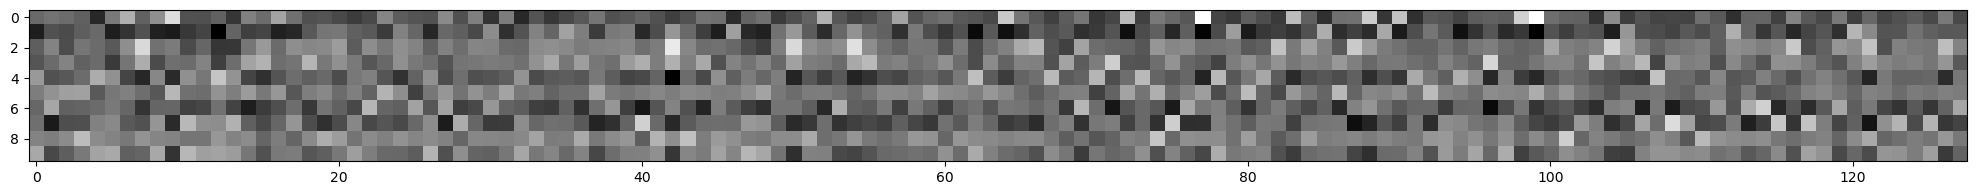

In [43]:
plt.figure(figsize=(20, 20))
plt.imshow(logits.T.detach(), cmap='gray')
plt.tight_layout()

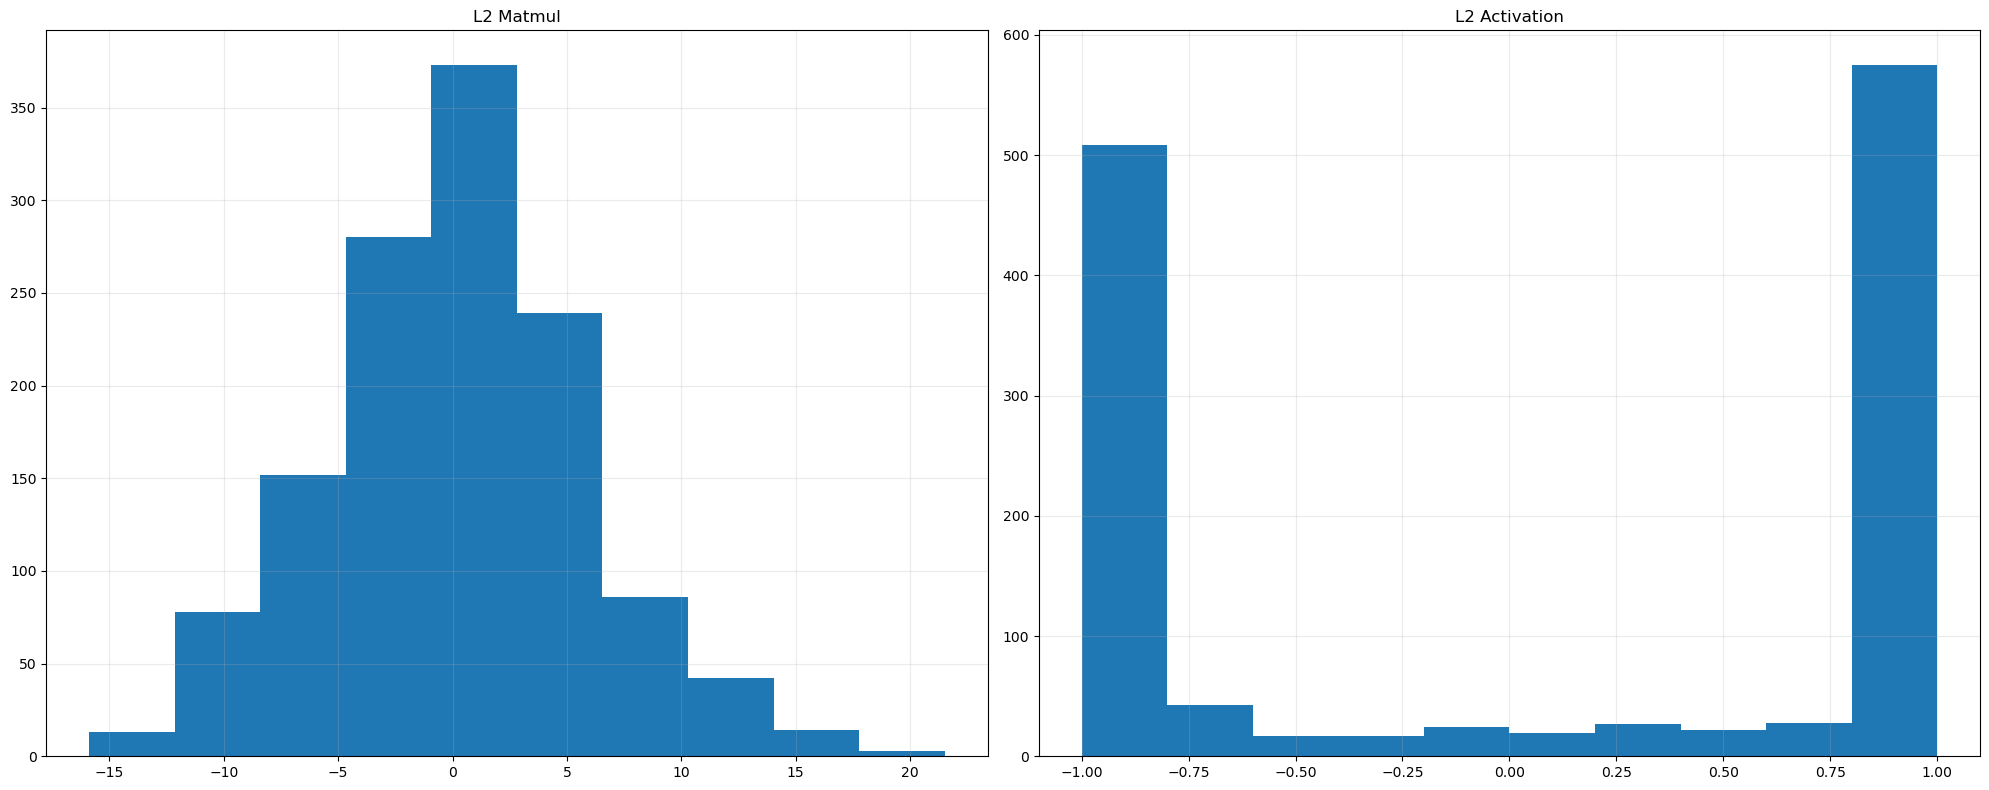

In [14]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hist(logits.view(-1).tolist(), 10)
plt.title("L2 Matmul")
plt.grid(alpha=0.25)

plt.subplot(1,2,2)
plt.hist(torch.tanh(logits).view(-1).tolist(), 10)
plt.title("L2 Activation")
plt.grid(alpha=0.25)
plt.tight_layout()

Probability: 97.13276624679565%
Prediction: 7


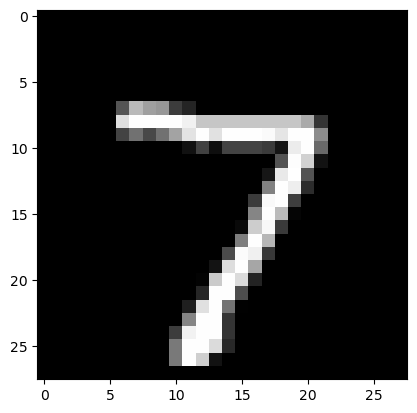

In [41]:
ds = sorted(list(zip(x_test, prob)), key=lambda x: np.max(x[0]), reverse=True) # ????

for m, p in ds:
    plt.imshow(m, 'gray')
    print("Probability:", str(torch.max(p).detach().numpy()*100) + "%")
    print("Prediction:", torch.argmax(p).numpy())
    break